In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import time
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow import keras

In [2]:


batch_size=64
img_height = 224
img_width = 224

num_of_test_samples = 1040



In [13]:
# train_generator = ImageDataGenerator(rotation_range=90, 
#                                      brightness_range=[0.1, 0.7],
#                                      width_shift_range=0.5, 
#                                      height_shift_range=0.5,
#                                      horizontal_flip=True, 
#                                      vertical_flip=True,
#                                      validation_split=0.15,
#                                      preprocessing_function=preprocess_input) # VGG16 preprocessing

# test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
download_dir = Path('D:/BaiTap/DoAnTotNghiep/dataset/')
train_data_dir = download_dir/'training'
test_data_dir = download_dir/'testing'
class_subset = sorted(os.listdir(train_data_dir))[:10]

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(train_data_dir),
    validation_split=0.2,    
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    shuffle=True,
    seed=42)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    os.path.join(train_data_dir),
    validation_split=0.2,    
    subset='validation',
    image_size=(img_height, img_width),
    batch_size=batch_size, 
    shuffle=True,
    seed=42)
# load testing data
test_ds = tf.keras.preprocessing.image_dataset_from_directory(   
    os.path.join(test_data_dir),
    batch_size=1,
    image_size=(img_height, img_width),
    shuffle=False,
    seed=42)


# traingen = train_generator.flow_from_directory(train_data_dir,
#                                                target_size=(img_height, img_width),
#                                                class_mode='categorical',
#                                                classes=class_subset,
#                                                subset='training',
#                                                batch_size=batch_size, 
#                                                shuffle=True,
#                                                seed=42)

# validgen = train_generator.flow_from_directory(train_data_dir,
#                                                target_size=(img_height, img_width),
#                                                class_mode='categorical',
#                                                classes=class_subset,
#                                                subset='validation',
#                                                batch_size=batch_size,
#                                                shuffle=True,
#                                                seed=42)

# testgen = test_generator.flow_from_directory(test_data_dir,
#                                              target_size=(img_height, img_width),
#                                              class_mode=None,
#                                              classes=class_subset,
#                                              batch_size=1,
#                                              shuffle=False,
#                                              seed=42)

Found 5879 files belonging to 5 classes.
Using 1175 files for validation.
Found 5879 files belonging to 5 classes.
Using 1175 files for validation.
Found 1049 files belonging to 5 classes.


In [8]:
# load model VGG16
def create_model(input_shape, n_classes, optimizer='adam', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False
    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [14]:
input_shape = (img_height, img_width, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=5
n_epochs = 20
# n_steps = traingen.samples // batch_size
# n_val_steps = validgen.samples // batch_size

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)
vgg_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [16]:
# Training



start_time = time.time()

vgg_history = vgg_model.fit(train_ds,                            
                            epochs=n_epochs,
                            validation_data=val_ds,                                                    
                            )
training_time = (time.time() - start_time)/60
print("---Training time: %s minutes ---" % training_time)

Epoch 1/20


ValueError: in user code:

    File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\losses.py", line 1787, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\backend.py", line 5119, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None, 1) and (None, 5) are incompatible


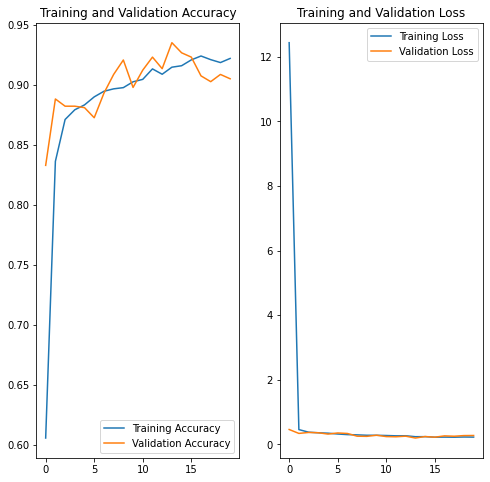

In [7]:
# # Visualize training results
acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']
loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']
epochs_range = range(n_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [8]:
# save the model
import pathlib
model_path = pathlib.Path('/BaiTap/DoAnTotNghiep/model/')
vgg_model.save(os.path.join(model_path,'vgg16x256x256.h5'))

In [9]:
# save the model
import pathlib
model_path = pathlib.Path('/BaiTap/DoAnTotNghiep/model/')
plant_model = keras.models.load_model(os.path.join(model_path, 'vgg16x256x256.h5'))

In [10]:
# evaluate train the model
_, accuracy = plant_model.evaluate(traingen, verbose=1)
print( 'Accuracy on the train set: %.2f' % (accuracy*100)+'%' )

79/79 [==============================] - 1564s 20s/step - loss: 0.2322 - accuracy: 0.9170
Accuracy on the train set: 91.70%


In [13]:
# evaluate test the model
true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = plant_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("Accuracy on the test set: {:.2f}%".format(vgg_acc * 100))

1049/1049 [==============================] - 392s 374ms/step
Accuracy on the test set: 91.99%


In [15]:
# specify test image filename
test_img_fn = os.path.join(download_dir, 'testing/Pepper__bell___healthy/3edf7c3f-73e0-439c-870d-76cfd7c3bc45___RS_HL 1859.jpg')

# read image
img = keras.preprocessing.image.load_img(
    test_img_fn, target_size=(img_height, img_height)
)

# convert image into array
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

# apply the model to predict flower name
prob = plant_model.predict(img_array)
predicted_class = class_subset[np.argmax(prob)]

# display the result
print('Predicted class: ', predicted_class, '(Probability = ', np.max(prob), ')')


1/1 [==============================] - 0s 404ms/step
Predicted class:  Pepper__bell___healthy (Probability =  1.0 )
